# Sentence Level Sentiment Predictator using Word Embeddings

# Generate Word Embedding

In the first section, we read sentiment labelled sentences from IMDB reviews and generate word embeddings.

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
sentences = pd.read_csv(
    'imdb_labelled.txt', sep='\|', engine='python',
    header=None, names=['sentence', 'sentiment_label']
)

In [3]:
sentences.head()

,sentence,sentiment_label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


These are the unique sentiment labels:

In [4]:
sentences.sentiment_label.unique()

array([0, 1], dtype=int64)

Let's check the label distribution

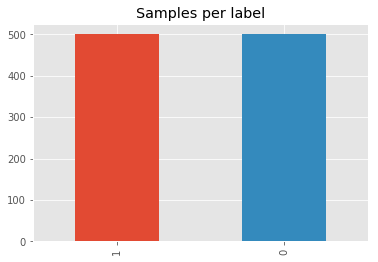

In [5]:
sentences.sentiment_label.value_counts().plot(kind='bar', title='Samples per label')

Thus this dataset is almost balanced - so we don't have to worry about the class imbalance problem too much.

In [6]:
sentences.shape

(1000, 2)

Each sentence is now a single string. Next we tokenize each sentences into a list of strings.

In [7]:
from nltk.tokenize import word_tokenize

sentences = sentences.assign(word_list=sentences.sentence.apply(word_tokenize))
sentences = sentences.drop('sentence', axis=1)

sentences.head()

,sentiment_label,word_list
0,0,"[A, very, ,, very, ,, very, slow-moving, ,, ai..."
1,0,"[Not, sure, who, was, more, lost, -, the, flat..."
2,0,"[Attempting, artiness, with, black, &, white, ..."
3,0,"[Very, little, music, or, anything, to, speak,..."
4,1,"[The, best, scene, in, the, movie, was, when, ..."


Now we'll use gensim to build the word embeddings and then convert the result into a DataFrame. The index of the dataframe are the words (vocabulary) in our dataset and each row contains the embedding vector.

In [8]:
from gensim.models.word2vec import Word2Vec

embeddings = Word2Vec(
    sentences.word_list.tolist(),
    # use skip-gram model,
    sg=1,
    # size of the embedding dimension
    size=10,
    # size of the context window    
    window=3,
    # for consistency, this affects the initial random embeddings
    seed=1234,
    # ignore words that appear less than this
    min_count=0,
    # Use negative sampling instead of hierarchical softmax
    hs=0
)

embedding_map = {w: embeddings.wv[w] for w in embeddings.wv.vocab}
embedding_df = pd.DataFrame.from_dict(embedding_map, orient='index')

embedding_df.head()

d:\Anaconda3\envs\keras\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


,0,1,2,3,4,5,6,7,8,9
A,-0.046067,-0.183315,0.507321,-0.176546,-0.248928,0.384711,0.393233,0.680458,-0.315859,-0.163710
very,-0.064760,-0.205842,0.702986,-0.123562,-0.352325,0.374808,0.511138,0.890570,-0.381449,-0.311933
",",-0.077799,-0.194600,0.825287,-0.232362,-0.393387,0.536801,0.652023,1.190048,-0.461544,-0.347977
slow-moving,-0.017554,0.000060,0.121923,0.010232,0.002762,0.065538,0.076900,0.135612,-0.009233,-0.072831
aimless,-0.025890,0.011001,0.113866,0.004751,-0.064764,0.026288,0.088881,0.133067,-0.026642,-0.011556


Note that since our original dataset was a mixture of uppercase and lowercase, we have ended up with two different embedding vectors for 'A' and 'a'. This could potentially be a problem  - for now we just make a note of it.

# Building the Classifier

In the first pass, we'll create a simple classifier using a Sequential model with one Dense layer followed by an output layer with sigmoid activation. In this classifier, we'll take the average of the embedding vectors for all the words that are in a given sentence (strictly speaking, the words that are common between the vocabulary and the list of words in the sentence, since we've filtered out the rare words in the embedding construction step).

In [9]:
def average_embedding(list_of_words, embeddings):
    """Return the average of the embedding vectors in `embeddings` for all the words in `list_of_words`. 
    If a word does not exist in `embeddings`, consider it's embeddings to be all zeros."""
    
    # The fillna(0) handles the missing word case 
    return embeddings.reindex(list_of_words, axis=0).fillna(0).mean(axis=0)

def sentence_embeddings(sents, embeddings):
    """Calculate average embeddings for each sentence."""
    sentence_embeddings = sents.word_list.apply(lambda word_list: average_embedding(word_list, embeddings))
    sentence_embeddings = sentence_embeddings.assign(sentiment_label=sents.sentiment_label)
    return sentence_embeddings   

In [10]:
input_df = sentence_embeddings(sentences, embedding_df)

In [11]:
input_df.head()

,0,1,2,3,4,5,6,7,8,9,sentiment_label
0,-0.042926,-0.148105,0.575592,-0.140602,-0.268451,0.353110,0.427335,0.755431,-0.296486,-0.224673,0
1,-0.009059,-0.139394,0.537527,-0.126475,-0.247286,0.347000,0.394486,0.729050,-0.274310,-0.192785,0
2,-0.031435,-0.153016,0.543911,-0.132631,-0.254814,0.352186,0.410118,0.734001,-0.268412,-0.206593,0
3,-0.006854,-0.149896,0.593891,-0.152073,-0.278693,0.386144,0.433150,0.783598,-0.317526,-0.221270,0
4,-0.018697,-0.160150,0.573916,-0.154065,-0.272173,0.356531,0.415648,0.751828,-0.288467,-0.203820,1


Now we split our data into a train and test sets.

In [12]:
train_df = input_df.groupby('sentiment_label').apply(lambda g: g.sample(frac=0.7, replace=False, random_state=4231))
train_df.index = train_df.index.droplevel(level=0)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,sentiment_label
838,-0.019435,-0.133985,0.565594,-0.137858,-0.275899,0.360477,0.408289,0.735270,-0.283110,-0.210047,0
139,-0.016961,-0.128489,0.529581,-0.136973,-0.233034,0.340669,0.399643,0.686084,-0.273909,-0.194145,0
174,-0.017202,-0.157779,0.585503,-0.140563,-0.257957,0.382709,0.416051,0.752946,-0.274260,-0.222843,0
227,-0.015950,-0.145161,0.526977,-0.128325,-0.243780,0.347248,0.381607,0.681917,-0.258176,-0.193921,0
15,-0.020370,-0.169573,0.597465,-0.144073,-0.281584,0.389461,0.453698,0.803016,-0.301227,-0.230050,0


In [13]:
test_df = input_df.drop(train_df.index, axis=0)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,sentiment_label
1,-0.009059,-0.139394,0.537527,-0.126475,-0.247286,0.347000,0.394486,0.729050,-0.274310,-0.192785,0
5,-0.033072,-0.139607,0.577956,-0.145244,-0.279555,0.372876,0.431658,0.791745,-0.297434,-0.222029,0
6,-0.014756,-0.127542,0.416245,-0.106317,-0.183163,0.268662,0.305142,0.548000,-0.217445,-0.142333,0
7,-0.025722,-0.152373,0.593671,-0.142071,-0.269999,0.362191,0.445455,0.790208,-0.301834,-0.227874,1
11,-0.033361,-0.153925,0.628671,-0.155574,-0.292488,0.389999,0.449822,0.831638,-0.318951,-0.239236,1


Let's double-check the label distributions in the train and test datasets:

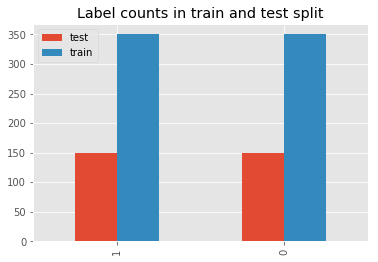

In [14]:
counts = pd.concat({
    'train': train_df.sentiment_label.value_counts(), 
    'test': test_df.sentiment_label.value_counts(), 
}, axis=1)

ax = counts.plot(kind='bar', title='Label counts in train and test split')

Now we're ready to build the model using Keras.

In [15]:
from keras import regularizers, Sequential
from keras.layers import Dense

minibatch_size = 32
# subtract 1 because input_df also contains the label column
embedding_size = input_df.shape[1] - 1

model = Sequential()
model.add(Dense(minibatch_size, 
                activation='relu', 
                input_dim=embedding_size, 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [16]:
n_epochs = 2000
y_train = pd.DataFrame(train_df.sentiment_label).astype(np.int32).values

# Scale the X values to zero mean and unit variance
X_train = train_df.drop('sentiment_label', axis=1)
X_train = X_train.sub(X_train.mean(axis=0)).div(X_train.std(axis=0)).astype(np.float32).values

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=minibatch_size, verbose=1)

Epoch 1/2000
700/700 [==============================] - 1s 926us/step - loss: 0.8606 - acc: 0.4829
Epoch 2/2000
700/700 [==============================] - 0s 63us/step - loss: 0.8268 - acc: 0.5329
Epoch 3/2000
700/700 [==============================] - 0s 61us/step - loss: 0.8132 - acc: 0.5429
Epoch 4/2000
700/700 [==============================] - 0s 57us/step - loss: 0.8040 - acc: 0.5400
Epoch 5/2000
700/700 [==============================] - 0s 53us/step - loss: 0.7938 - acc: 0.5629
Epoch 6/2000
700/700 [==============================] - 0s 51us/step - loss: 0.7863 - acc: 0.5657
Epoch 7/2000
700/700 [==============================] - 0s 57us/step - loss: 0.7783 - acc: 0.5600
Epoch 8/2000
700/700 [==============================] - 0s 54us/step - loss: 0.7722 - acc: 0.5643
Epoch 9/2000
700/700 [==============================] - 0s 56us/step - loss: 0.7658 - acc: 0.5686
Epoch 10/2000
700/700 [==============================] - 0s 51us/step - loss: 0.7604 - acc: 0.5671
Epoch 11/2000
700/

700/700 [==============================] - 0s 54us/step - loss: 0.6786 - acc: 0.5743
Epoch 84/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6768 - acc: 0.5843
Epoch 85/2000
700/700 [==============================] - 0s 67us/step - loss: 0.6764 - acc: 0.5786
Epoch 86/2000
700/700 [==============================] - 0s 63us/step - loss: 0.6773 - acc: 0.5729
Epoch 87/2000
700/700 [==============================] - 0s 61us/step - loss: 0.6769 - acc: 0.5700
Epoch 88/2000
700/700 [==============================] - 0s 63us/step - loss: 0.6794 - acc: 0.5743
Epoch 89/2000
700/700 [==============================] - 0s 70us/step - loss: 0.6765 - acc: 0.5771
Epoch 90/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6771 - acc: 0.5714
Epoch 91/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6763 - acc: 0.5786
Epoch 92/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6760 - acc: 0.5829
Epoch 93/2000
700/700 [=

700/700 [==============================] - 0s 57us/step - loss: 0.6723 - acc: 0.5800
Epoch 166/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6739 - acc: 0.5886
Epoch 167/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6741 - acc: 0.5700
Epoch 168/2000
700/700 [==============================] - 0s 60us/step - loss: 0.6717 - acc: 0.5757
Epoch 169/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6719 - acc: 0.5871
Epoch 170/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6729 - acc: 0.5700
Epoch 171/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6734 - acc: 0.5771
Epoch 172/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6717 - acc: 0.5757
Epoch 173/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6718 - acc: 0.5843
Epoch 174/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6713 - acc: 0.5800
Epoch 175/2000


700/700 [==============================] - 0s 61us/step - loss: 0.6688 - acc: 0.5871
Epoch 248/2000
700/700 [==============================] - 0s 64us/step - loss: 0.6690 - acc: 0.5829
Epoch 249/2000
700/700 [==============================] - ETA: 0s - loss: 0.6854 - acc: 0.593 - 0s 57us/step - loss: 0.6695 - acc: 0.5871
Epoch 250/2000
700/700 [==============================] - 0s 63us/step - loss: 0.6692 - acc: 0.5829
Epoch 251/2000
700/700 [==============================] - 0s 67us/step - loss: 0.6687 - acc: 0.5829
Epoch 252/2000
700/700 [==============================] - 0s 66us/step - loss: 0.6691 - acc: 0.5814
Epoch 253/2000
700/700 [==============================] - 0s 71us/step - loss: 0.6699 - acc: 0.5814
Epoch 254/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6697 - acc: 0.5829
Epoch 255/2000
700/700 [==============================] - 0s 67us/step - loss: 0.6682 - acc: 0.5829
Epoch 256/2000
700/700 [==============================] - 0s 57us/step - loss

700/700 [==============================] - 0s 87us/step - loss: 0.6664 - acc: 0.5843
Epoch 329/2000
700/700 [==============================] - 0s 63us/step - loss: 0.6666 - acc: 0.5914
Epoch 330/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6674 - acc: 0.5900
Epoch 331/2000
700/700 [==============================] - 0s 61us/step - loss: 0.6680 - acc: 0.5971
Epoch 332/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6680 - acc: 0.5857
Epoch 333/2000
700/700 [==============================] - 0s 60us/step - loss: 0.6652 - acc: 0.5957
Epoch 334/2000
700/700 [==============================] - 0s 77us/step - loss: 0.6660 - acc: 0.6029
Epoch 335/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6687 - acc: 0.5929
Epoch 336/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6659 - acc: 0.5971
Epoch 337/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6659 - acc: 0.5971
Epoch 338/2000


700/700 [==============================] - 0s 49us/step - loss: 0.6615 - acc: 0.6029
Epoch 411/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6611 - acc: 0.6057
Epoch 412/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6632 - acc: 0.5971
Epoch 413/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6634 - acc: 0.6043
Epoch 414/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6648 - acc: 0.5929
Epoch 415/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6677 - acc: 0.6000
Epoch 416/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6633 - acc: 0.6000
Epoch 417/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6617 - acc: 0.5971
Epoch 418/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6614 - acc: 0.6086
Epoch 419/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6616 - acc: 0.6057
Epoch 420/2000


Epoch 492/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6579 - acc: 0.6143
Epoch 493/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6582 - acc: 0.6071
Epoch 494/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6596 - acc: 0.6129
Epoch 495/2000
700/700 [==============================] - 0s 60us/step - loss: 0.6583 - acc: 0.6171
Epoch 496/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6593 - acc: 0.6300
Epoch 497/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6596 - acc: 0.6029
Epoch 498/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6580 - acc: 0.6043
Epoch 499/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6594 - acc: 0.6000
Epoch 500/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6569 - acc: 0.6114
Epoch 501/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6563 - acc: 0.6186


700/700 [==============================] - 0s 51us/step - loss: 0.6554 - acc: 0.6214
Epoch 574/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6548 - acc: 0.6243
Epoch 575/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6560 - acc: 0.6214
Epoch 576/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6543 - acc: 0.6229
Epoch 577/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6521 - acc: 0.6229
Epoch 578/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6541 - acc: 0.6114
Epoch 579/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6561 - acc: 0.6286
Epoch 580/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6529 - acc: 0.6214
Epoch 581/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6532 - acc: 0.6229
Epoch 582/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6505 - acc: 0.6286
Epoch 583/2000


700/700 [==============================] - 0s 50us/step - loss: 0.6485 - acc: 0.6429
Epoch 656/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6481 - acc: 0.6329
Epoch 657/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6492 - acc: 0.6286
Epoch 658/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6586 - acc: 0.6171
Epoch 659/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6509 - acc: 0.6229
Epoch 660/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6474 - acc: 0.6286
Epoch 661/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6490 - acc: 0.6343
Epoch 662/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6508 - acc: 0.6214
Epoch 663/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6496 - acc: 0.6286
Epoch 664/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6498 - acc: 0.6357
Epoch 665/2000


700/700 [==============================] - 0s 50us/step - loss: 0.6479 - acc: 0.6400
Epoch 737/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6477 - acc: 0.6300
Epoch 738/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6442 - acc: 0.6457
Epoch 739/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6482 - acc: 0.6371
Epoch 740/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6457 - acc: 0.6386
Epoch 741/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6441 - acc: 0.6529
Epoch 742/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6435 - acc: 0.6400
Epoch 743/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6431 - acc: 0.6457
Epoch 744/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6448 - acc: 0.6386
Epoch 745/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6446 - acc: 0.6414
Epoch 746/2000


700/700 [==============================] - 0s 50us/step - loss: 0.6404 - acc: 0.6543
Epoch 819/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6414 - acc: 0.6529
Epoch 820/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6407 - acc: 0.6614
Epoch 821/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6422 - acc: 0.6500
Epoch 822/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6431 - acc: 0.6429
Epoch 823/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6438 - acc: 0.6557
Epoch 824/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6402 - acc: 0.6543
Epoch 825/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6421 - acc: 0.6471
Epoch 826/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6418 - acc: 0.6529
Epoch 827/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6399 - acc: 0.6543
Epoch 828/2000


700/700 [==============================] - 0s 51us/step - loss: 0.6391 - acc: 0.6529
Epoch 901/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6387 - acc: 0.6571
Epoch 902/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6436 - acc: 0.6443
Epoch 903/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6534 - acc: 0.6371
Epoch 904/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6526 - acc: 0.6443
Epoch 905/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6401 - acc: 0.6500
Epoch 906/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6390 - acc: 0.6586
Epoch 907/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6375 - acc: 0.6543
Epoch 908/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6403 - acc: 0.6643
Epoch 909/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6480 - acc: 0.6529
Epoch 910/2000


700/700 [==============================] - 0s 50us/step - loss: 0.6351 - acc: 0.6586
Epoch 983/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6367 - acc: 0.6671
Epoch 984/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6370 - acc: 0.6457
Epoch 985/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6407 - acc: 0.6500
Epoch 986/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6411 - acc: 0.6386
Epoch 987/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6375 - acc: 0.6543
Epoch 988/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6354 - acc: 0.6657
Epoch 989/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6362 - acc: 0.6514
Epoch 990/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6381 - acc: 0.6486
Epoch 991/2000
700/700 [==============================] - 0s 47us/step - loss: 0.6380 - acc: 0.6414
Epoch 992/2000


700/700 [==============================] - 0s 54us/step - loss: 0.6325 - acc: 0.6600
Epoch 1064/2000
700/700 [==============================] - 0s 66us/step - loss: 0.6335 - acc: 0.6557
Epoch 1065/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6324 - acc: 0.6600
Epoch 1066/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6325 - acc: 0.6614
Epoch 1067/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6325 - acc: 0.6657
Epoch 1068/2000
700/700 [==============================] - 0s 60us/step - loss: 0.6346 - acc: 0.6571
Epoch 1069/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6362 - acc: 0.6586
Epoch 1070/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6346 - acc: 0.6557
Epoch 1071/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6327 - acc: 0.6643
Epoch 1072/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6405 - acc: 0.6671
Epoch 

700/700 [==============================] - 0s 50us/step - loss: 0.6313 - acc: 0.6714
Epoch 1145/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6430 - acc: 0.6514
Epoch 1146/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6395 - acc: 0.6614
Epoch 1147/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6361 - acc: 0.6457
Epoch 1148/2000
700/700 [==============================] - 0s 60us/step - loss: 0.6292 - acc: 0.6614
Epoch 1149/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6333 - acc: 0.6529
Epoch 1150/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6312 - acc: 0.6571
Epoch 1151/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6320 - acc: 0.6686
Epoch 1152/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6371 - acc: 0.6486
Epoch 1153/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6323 - acc: 0.6586
Epoch 

700/700 [==============================] - 0s 50us/step - loss: 0.6315 - acc: 0.6586
Epoch 1226/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6261 - acc: 0.6729
Epoch 1227/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6332 - acc: 0.6557
Epoch 1228/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6296 - acc: 0.6686
Epoch 1229/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6292 - acc: 0.6671
Epoch 1230/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6333 - acc: 0.6657
Epoch 1231/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6312 - acc: 0.6614
Epoch 1232/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6278 - acc: 0.6729
Epoch 1233/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6296 - acc: 0.6457
Epoch 1234/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6346 - acc: 0.6543
Epoch 

700/700 [==============================] - 0s 61us/step - loss: 0.6359 - acc: 0.6629
Epoch 1307/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6287 - acc: 0.6700
Epoch 1308/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6284 - acc: 0.6614
Epoch 1309/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6341 - acc: 0.6686
Epoch 1310/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6359 - acc: 0.6529
Epoch 1311/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6294 - acc: 0.6686
Epoch 1312/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6269 - acc: 0.6671
Epoch 1313/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6301 - acc: 0.6729
Epoch 1314/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6286 - acc: 0.6657
Epoch 1315/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6249 - acc: 0.6571
Epoch 

700/700 [==============================] - 0s 54us/step - loss: 0.6249 - acc: 0.6814
Epoch 1387/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6277 - acc: 0.6729
Epoch 1388/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6267 - acc: 0.6671
Epoch 1389/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6241 - acc: 0.6629
Epoch 1390/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6280 - acc: 0.6714
Epoch 1391/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6316 - acc: 0.6500
Epoch 1392/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6257 - acc: 0.6743
Epoch 1393/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6275 - acc: 0.6671
Epoch 1394/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6281 - acc: 0.6771
Epoch 1395/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6349 - acc: 0.6643
Epoch 

700/700 [==============================] - 0s 50us/step - loss: 0.6240 - acc: 0.6771
Epoch 1468/2000
700/700 [==============================] - 0s 60us/step - loss: 0.6248 - acc: 0.6586
Epoch 1469/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6297 - acc: 0.6671
Epoch 1470/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6288 - acc: 0.6714
Epoch 1471/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6238 - acc: 0.6657
Epoch 1472/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6239 - acc: 0.6786
Epoch 1473/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6231 - acc: 0.6814
Epoch 1474/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6262 - acc: 0.6571
Epoch 1475/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6246 - acc: 0.6700
Epoch 1476/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6214 - acc: 0.6814
Epoch 

700/700 [==============================] - 0s 56us/step - loss: 0.6271 - acc: 0.6571
Epoch 1549/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6260 - acc: 0.6800
Epoch 1550/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6199 - acc: 0.6843
Epoch 1551/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6236 - acc: 0.6671
Epoch 1552/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6248 - acc: 0.6700
Epoch 1553/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6223 - acc: 0.6743
Epoch 1554/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6261 - acc: 0.6600
Epoch 1555/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6204 - acc: 0.6729
Epoch 1556/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6236 - acc: 0.6843
Epoch 1557/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6236 - acc: 0.6857
Epoch 

700/700 [==============================] - 0s 57us/step - loss: 0.6296 - acc: 0.6757
Epoch 1630/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6306 - acc: 0.6586
Epoch 1631/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6233 - acc: 0.6757
Epoch 1632/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6211 - acc: 0.6686
Epoch 1633/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6189 - acc: 0.6814
Epoch 1634/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6244 - acc: 0.6857
Epoch 1635/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6217 - acc: 0.6743
Epoch 1636/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6195 - acc: 0.6814
Epoch 1637/2000
700/700 [==============================] - 0s 49us/step - loss: 0.6209 - acc: 0.6714
Epoch 1638/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6254 - acc: 0.6686
Epoch 

700/700 [==============================] - 0s 52us/step - loss: 0.6249 - acc: 0.6714
Epoch 1711/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6206 - acc: 0.6786
Epoch 1712/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6217 - acc: 0.6814
Epoch 1713/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6211 - acc: 0.6829
Epoch 1714/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6213 - acc: 0.6586
Epoch 1715/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6216 - acc: 0.6771
Epoch 1716/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6213 - acc: 0.6757
Epoch 1717/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6217 - acc: 0.6843
Epoch 1718/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6177 - acc: 0.6871
Epoch 1719/2000
700/700 [==============================] - 0s 54us/step - loss: 0.6243 - acc: 0.6843
Epoch 

700/700 [==============================] - 0s 50us/step - loss: 0.6182 - acc: 0.6857
Epoch 1791/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6178 - acc: 0.6829
Epoch 1792/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6166 - acc: 0.6900
Epoch 1793/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6197 - acc: 0.6714
Epoch 1794/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6193 - acc: 0.6800
Epoch 1795/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6212 - acc: 0.6771
Epoch 1796/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6203 - acc: 0.6786
Epoch 1797/2000
700/700 [==============================] - 0s 57us/step - loss: 0.6189 - acc: 0.6900
Epoch 1798/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6151 - acc: 0.6814
Epoch 1799/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6206 - acc: 0.6829
Epoch 

700/700 [==============================] - 0s 49us/step - loss: 0.6167 - acc: 0.6829
Epoch 1872/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6168 - acc: 0.6871
Epoch 1873/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6150 - acc: 0.6900
Epoch 1874/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6169 - acc: 0.6714
Epoch 1875/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6225 - acc: 0.6743
Epoch 1876/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6183 - acc: 0.6771
Epoch 1877/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6182 - acc: 0.6843
Epoch 1878/2000
700/700 [==============================] - 0s 53us/step - loss: 0.6130 - acc: 0.6829
Epoch 1879/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6144 - acc: 0.6843
Epoch 1880/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6158 - acc: 0.6786
Epoch 

700/700 [==============================] - 0s 54us/step - loss: 0.6194 - acc: 0.6743
Epoch 1953/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6152 - acc: 0.6771
Epoch 1954/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6192 - acc: 0.6700
Epoch 1955/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6188 - acc: 0.6786
Epoch 1956/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6210 - acc: 0.6643
Epoch 1957/2000
700/700 [==============================] - 0s 50us/step - loss: 0.6167 - acc: 0.6686
Epoch 1958/2000
700/700 [==============================] - 0s 51us/step - loss: 0.6204 - acc: 0.6743
Epoch 1959/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6189 - acc: 0.6814
Epoch 1960/2000
700/700 [==============================] - 0s 56us/step - loss: 0.6155 - acc: 0.6800
Epoch 1961/2000
700/700 [==============================] - 0s 59us/step - loss: 0.6240 - acc: 0.6743
Epoch 

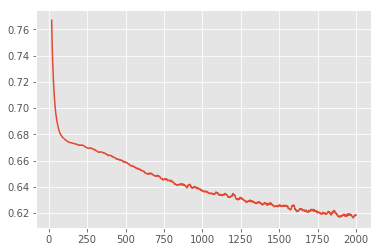

In [17]:
losses = history.history['loss']
ax = pd.Series(losses).rolling(20).mean().plot()

Now let's evaluate our model against the test set.

In [18]:
y_test = pd.DataFrame(test_df.sentiment_label).astype(np.int32).values

# Scale the X values to zero mean and unit variance
X_test = test_df.drop('sentiment_label', axis=1)
X_test = X_test.sub(X_test.mean(axis=0)).div(X_test.std(axis=0)).astype(np.float32).values

train_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print('train_accuracy: {:.4f}, test_accuracy: {:.4f}'.format(train_accuracy, test_accuracy))

300/300 [==============================] - 0s 117us/step
train_accuracy: 0.7307, test_accuracy: 0.5500


In [19]:
predictions = model.predict(X_test).squeeze()
predictions = np.where(predictions > 0.5, 1, 0)
pred_series = pd.Series(index=test_df.index.copy(), data=predictions, name='predictions')

results_df = pd.concat({'predictions': pred_series, 'actual': test_df.sentiment_label}, axis=1)
results_df.head()

,actual,predictions
1,0,1
5,0,1
6,0,1
7,1,0
11,1,1


Now we generate the Confusion Matrix.

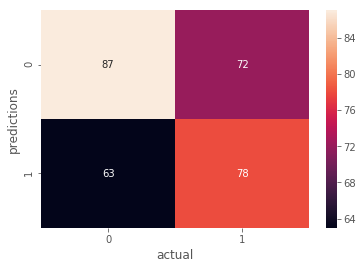

In [20]:
import seaborn as sns
v = pd.crosstab(results_df.predictions, results_df.actual)
sns.heatmap(v, annot=True)